# Deteksi Emosi dari Rekaman Suara Menggunakan Keras dan TensorFlow

## Persiapan Environment

Install library tambahan yang dibutuhkan


1. pydub : library untuk melakukan manipulasi pada data audio
2. noisereduce : library untuk mengurangi gangguan pada audio
3. json-tricks : package library python yang memiliki banyak fungsi untuk menangani json.






In [1]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

# Restart kernel sebelum eksekusi cell selanjutnya

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


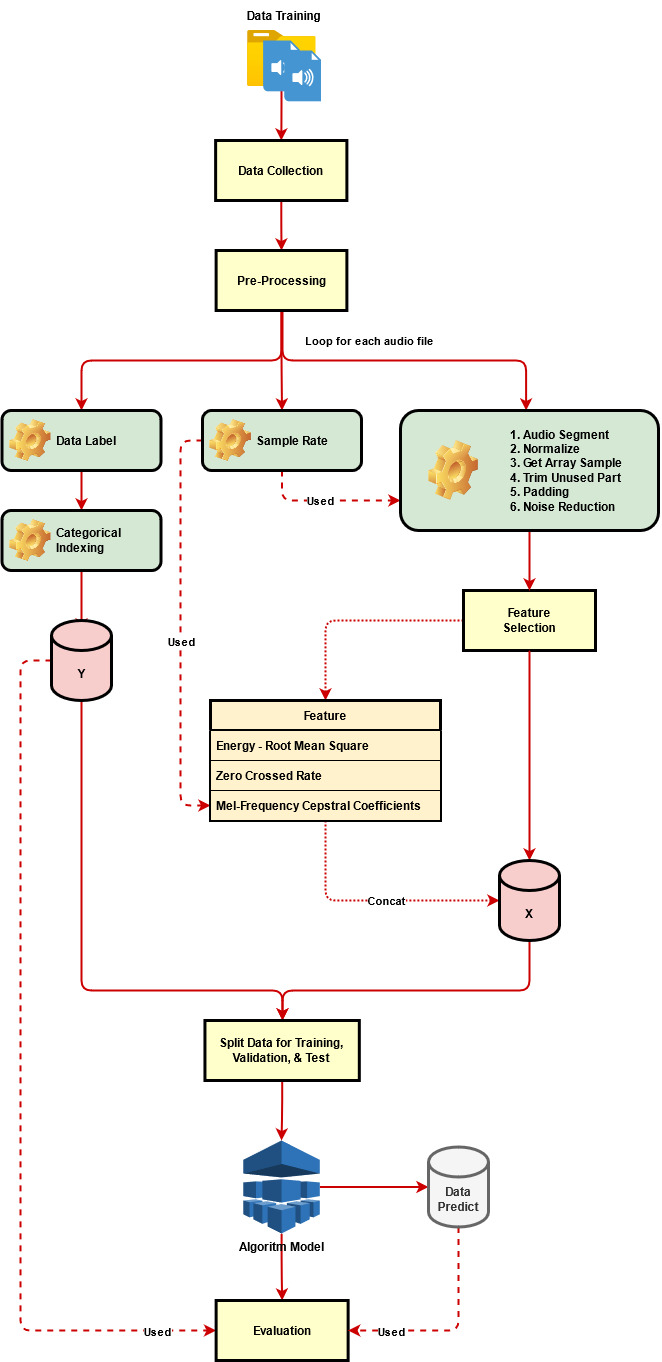

In [3]:
%%capture
import os
import numpy as np
from json_tricks import dump, load

import IPython.display as ipd
from pydub import AudioSegment, effects
import librosa
import librosa.display
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 
from keras.models import load_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 

import time

## Persiapan dan Pra-pemrosesan Dataset

Dataset yang digunakan :

[Dataset Speech Recognition](https://drive.google.com/drive/folders/1044UNhHvhhoWpKKEjVhXDAXFPM-JhO_i?usp=sharing)<br><br>


Setelah dipelajari, dari dataset yang tersedia telah ditentukan dataset yang akan digunakan yaitu :

[TESS](https://tspace.library.utoronto.ca/handle/1807/24487) (*Toronto Emotional Speech Set*) : Hanya terdiri dari 2 aktor dengan lebih fokus ke perbedaan umur aktor yaitu 26 dan 64 tahun dengan total file 2800. Terdapat 7 kelompok emosi yaitu : neutral, happiness, sadness, anger, fear, disgust, pleasant surprise. Penanda label emosi terdapat nama file dengan secara jelas menunjukan emosi seperti misal happy, sad, dan sebagainya.<br>
Contoh :  OAF_back_**fear**.wav => FEAR




In [4]:
folder_path = '/content/drive/MyDrive/Proa-ML/demo_day'
audio_path = folder_path + "/Tess"
 
columns = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'pleasant surprise']

# audio_rate = 16000
total_length = 131072 
frame_length = 2048
hop_length = 512

batch_size = 128
epocs = 300

data_ready_x = folder_path + '/data_ready/sr_x.json'
data_ready_y = folder_path + '/data_ready/sr_y.json'

best_path = folder_path + '/model/best_model_sr.hdf5'
model_path = folder_path + '/model/model_sr.h5'
weight_path = folder_path + '/model/model_weight_sr.h5'

In [5]:
# Mencari maksimal length dari sample
sample_length = []
for subdir, dirs, files in os.walk(audio_path):
  for file_name in files: 
    voice, sr = librosa.load(path = os.path.join(subdir, file_name), sr = None)
    xt, index = librosa.effects.trim(voice, top_db=30)
    sample_length.append(len(xt))

print('Panjang maksimal : ', np.max(sample_length))

Panjang maksimal :  131072


In [6]:
# 'neutral' = 0, 'happy' = 1, 'sad' = 2, 'angry' = 3, 'fear' = 4, 'disgust' = 5, 'sp = 6
def get_emot_on_file(name : str): 
  tmp_index = '-1'
  if ('neutral' in name.lower()) : 
    tmp_index = 0
  elif ('happy' in name.lower()) : 
    tmp_index = 1
  elif ('sad' in name.lower()) : 
    tmp_index = 2
  elif ('angry' in name.lower()) : 
    tmp_index = 3
  elif ('fear' in name.lower()) : 
    tmp_index = 4
  elif ('disgust' in name.lower()) : 
    tmp_index = 5
  elif ('ps' in name.lower()) : # pleasant surprise
    tmp_index = 6
  return tmp_index

def get_feature(file_dir : str, file_name : str) :
  # print(file_name)
  voice, sampling_rate = librosa.load(path = os.path.join(file_dir, file_name), sr = None)
  raw_voice = AudioSegment.from_file(os.path.join(file_dir,file_name)) 
  norm_voice = effects.normalize(raw_voice, headroom = 0)
  norm_x = np.array(norm_voice.get_array_of_samples(), dtype = 'float32')
  xt, index = librosa.effects.trim(norm_x, top_db=30)
  padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
  result_x = nr.reduce_noise(padded_x, sr = sampling_rate)
       
  feature_1 = librosa.feature.rms(result_x, 
                                  frame_length = frame_length, 
                                  hop_length = hop_length) 
  feature_2 = librosa.feature.zero_crossing_rate(result_x, 
                                                 frame_length = frame_length, 
                                                 hop_length = hop_length, 
                                                 center = True)       
  feature_3 = librosa.feature.mfcc(result_x, 
                                   sr = sampling_rate, 
                                   n_mfcc = 13, 
                                   hop_length = hop_length) 
  
  print(file_name, "\t", sampling_rate, "\t", len(xt), "\t", raw_voice.dBFS, "\t", norm_voice.dBFS)
  return feature_1, feature_2, feature_3

Sampling Rate :  22050


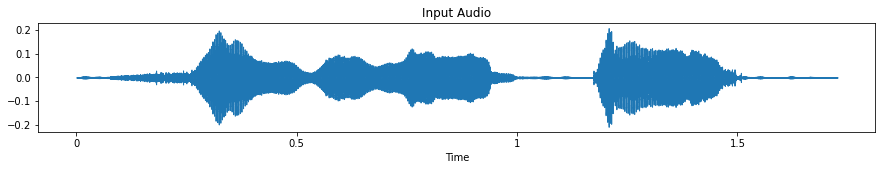

In [7]:
# Contoh audio asli
file_name = audio_path + '/OAF_Fear/OAF_back_fear.wav'
voice, sampling_rate = librosa.load(file_name)
plt.figure(figsize=(15,2))
plt.title("Input Audio")
librosa.display.waveshow(voice, sr = sampling_rate)
print("Sampling Rate : ", sampling_rate)
ipd.Audio(file_name)

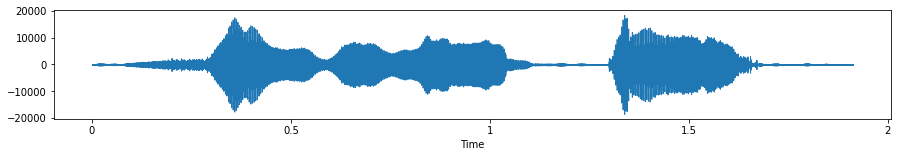

In [8]:
# Setelah dilakukan segmentasi dan normalisasi, kemudian simpan ke variabel sebagai numpy array.
raw_voice = AudioSegment.from_file(file_name)
norm_voice = effects.normalize(raw_voice, headroom = 5.0) 
norm_x = np.array(norm_voice.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(15,2))
librosa.display.waveshow(norm_x, sr = sampling_rate)

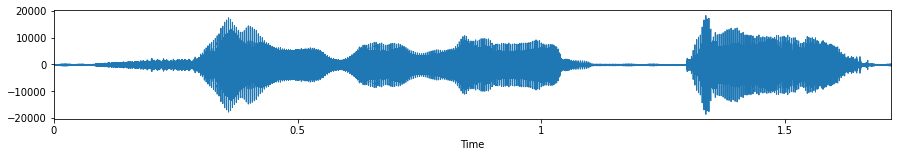

In [9]:
# Potong bagian yang ada di depan dan belakang rekaman suara.
xt, _ = librosa.effects.trim(norm_x, top_db=30)
plt.figure(figsize=(15,2))
librosa.display.waveplot(xt, sampling_rate)

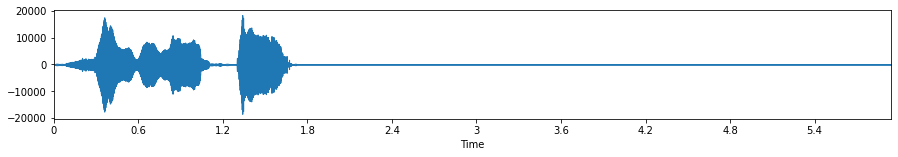

In [10]:
# Memberikan padding pada bagian kanan audio dengan panjang keseluruhan 
padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')

plt.figure(figsize=(15,2))
librosa.display.waveplot(padded_x, sampling_rate)

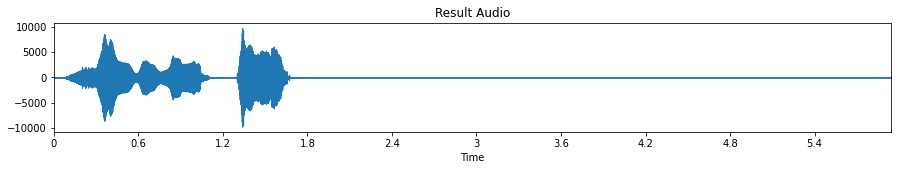

In [11]:
# Menghilangkan noise jika memang ada
result_x = nr.reduce_noise(padded_x, sr = sampling_rate)

plt.figure(figsize=(15,2))
plt.title('Result Audio')
librosa.display.waveplot(result_x, sampling_rate)
ipd.display(ipd.Audio(data = result_x, rate = sampling_rate))

## Pemilihan Fitur dan Split Data untuk Training dan Validasi

[Librosa Features](https://librosa.org/doc/main/feature.html)

Mengambil fitur dari audio :

<p>RMS  : Energy - Root Mean Square.<br>
ZCR  : Zero Crossed Rate.<br>
MFCC : Mel-Frequency Cepstral Coefficients.

<p>frame_length = 2048 & hop_length = 512.<br>
2048/512 = 4<br>
Artinya setiap 2048 sampel akan dilakukan analisa dan translasi sebanyak 4 nilai feature sekuensial<br><br>
total_length = 131072.<br>
(131072+1)/512 = 256,001953125 => Round up : 257<br>
Dengan panjang audio disamakan menjadi 131072, akan mendapatkan 257 nilai sekuensial untuk setiap feature.

</p>


In [12]:
%%time
# %%capture

rms = []
zcr = []
mfcc = []
emot_list = []

for subdir, dirs, files in os.walk(audio_path):
  for file_name in files:
    emot_index = get_emot_on_file(file_name)
    print(file_name, "\t", emot_index)
    emot_list.append(emot_index)                    
    f1, f2, f3 =  get_feature(subdir, file_name)
    rms.append(f1)
    zcr.append(f2)
    mfcc.append(f3)

Output streaming akan dipotong hingga 5000 baris terakhir.
OAF_tool_neutral.wav 	 0
OAF_tool_neutral.wav 	 24414 	 46915 	 -36.81177588443812 	 -12.464879779678906
OAF_mess_neutral.wav 	 0
OAF_mess_neutral.wav 	 24414 	 51988 	 -37.619453295979724 	 -12.100779900900594
OAF_mob_neutral.wav 	 0
OAF_mob_neutral.wav 	 24414 	 44815 	 -38.59978410902434 	 -11.462883641276475
OAF_page_neutral.wav 	 0
OAF_page_neutral.wav 	 24414 	 52375 	 -37.400553312212516 	 -11.948391963496757
OAF_ripe_neutral.wav 	 0
OAF_ripe_neutral.wav 	 24414 	 49929 	 -38.18137139698226 	 -10.69439116847545
OAF_sell_neutral.wav 	 0
OAF_sell_neutral.wav 	 24414 	 54732 	 -37.2640718791279 	 -11.96309068028057
OAF_rose_neutral.wav 	 0
OAF_rose_neutral.wav 	 24414 	 50687 	 -38.267798872635105 	 -13.634584890301692
OAF_thought_neutral.wav 	 0
OAF_thought_neutral.wav 	 24414 	 44539 	 -37.459708294351934 	 -11.039853496860205
OAF_pain_neutral.wav 	 0
OAF_pain_neutral.wav 	 24414 	 46873 	 -37.98999766606634 	 -11.3329177

In [13]:
# Ubah feature menajadi bentuk 3D : batch, timestep, feature
formated_zcr = np.asarray(zcr).astype('float32')
formated_zcr = np.swapaxes(formated_zcr,1,2)
print('ZCR : ', formated_zcr.shape)

formated_rms = np.asarray(rms).astype('float32')
formated_rms = np.swapaxes(formated_rms,1,2)
print('RMS : ', formated_rms.shape)

formated_mfcc = np.asarray(mfcc).astype('float32')
formated_mfcc = np.swapaxes(formated_mfcc,1,2)
print('MFCC:', formated_mfcc.shape)


ZCR :  (2800, 257, 1)
RMS :  (2800, 257, 1)
MFCC: (2800, 257, 13)


In [14]:
# Variabel X diambil dari gabungan ZCR, RMS, dan MFCC
X = np.concatenate((formated_zcr, formated_rms, formated_mfcc), axis=2)

# Variabel Y diambil dari list emosi
Y = np.asarray(emot_list).astype('int8')
Y = np.expand_dims(Y, axis=1)

### Simpan Data Pra-pemrosesan 

Simpan data yang sudah di-proses, sebagai cekpoin agar bisa di load ulang tanpa melakukan proses dari awal.

In [15]:
x_data = X.tolist() 
dump(obj = x_data, fp = data_ready_x)
y_data = Y.tolist() 
dump(obj = y_data, fp = data_ready_y)

'[[3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3]

### Load Data Pra-pemrosesan 

Buka kembali data yang sudah di-proses, tidak perlu proses dari awal jika menggunakan data ready yang sama.

In [16]:
X = load(data_ready_x)
X = np.asarray(X, dtype = 'float32')

Y = load(data_ready_y)
Y = np.asarray(Y, dtype = 'int8')

### Split dataset

In [17]:
# Split menjadi dataframe train & validation, and test dataset.
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.3, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.325, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 7, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 7, dtype = 'int8')
y_test_class = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')

print(np.unique(y_val))

[0 1 2 3 4 5 6]


In [18]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train_class))
print(np.shape(y_val_class))
print(np.shape(y_test_class))

(1960, 257, 15)
(567, 257, 15)
(273, 257, 15)
(1960, 7)
(567, 7)
(273, 7)


## Pembuatan Model dan Evaluasi

In [19]:
model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(7, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 257, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 53,959
Trainable params: 53,959
Non-trainable params: 0
_________________________________________________________________


In [20]:
%%time

# Simpan hanya model dengan model terbaik sebagai cek poin model
mcp_save = callbacks.ModelCheckpoint(best_path, 
                                     save_best_only = True,
                                     monitor = 'val_categorical_accuracy',
                                     mode = 'max')

# Proses mengurangi learning rate setelan n epoch tanpa perbaikan
rlrop = callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy', 
                                    factor = 0.1, 
                                    patience = 100)

# Model compile menggunakan RMSProp bukan Adam, dengan metric nya categorical accuracy                               
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'RMSProp', 
              metrics = ['categorical_accuracy'])


history = model.fit(x_train, 
                    y_train_class, 
                    epochs = epocs, 
                    batch_size = batch_size, 
                    validation_data = (x_val, y_val_class), 
                    callbacks = [mcp_save, rlrop])

# Load model dari hasil yang terbaik
model.load_weights(best_path)

Epoch 1/300
16/16 [==============================] - 16s 716ms/step - loss: 1.9614 - categorical_accuracy: 0.1577 - val_loss: 1.9507 - val_categorical_accuracy: 0.1693 - lr: 0.0010
Epoch 2/300
16/16 [==============================] - 10s 639ms/step - loss: 1.9389 - categorical_accuracy: 0.1750 - val_loss: 1.9221 - val_categorical_accuracy: 0.1817 - lr: 0.0010
Epoch 3/300
16/16 [==============================] - 10s 642ms/step - loss: 1.9100 - categorical_accuracy: 0.1934 - val_loss: 1.9186 - val_categorical_accuracy: 0.1993 - lr: 0.0010
Epoch 4/300
16/16 [==============================] - 10s 636ms/step - loss: 1.8795 - categorical_accuracy: 0.2240 - val_loss: 1.8835 - val_categorical_accuracy: 0.2205 - lr: 0.0010
Epoch 5/300
16/16 [==============================] - 10s 621ms/step - loss: 1.8479 - categorical_accuracy: 0.2520 - val_loss: 1.8776 - val_categorical_accuracy: 0.2011 - lr: 0.0010
Epoch 6/300
16/16 [==============================] - 10s 627ms/step - loss: 1.8293 - categorica

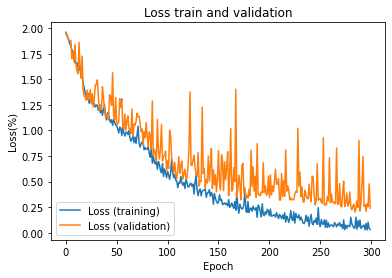

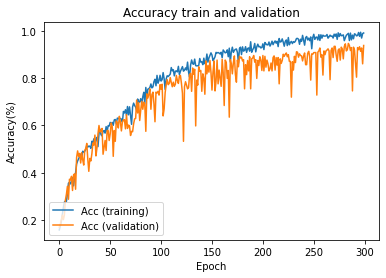

In [21]:
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss train and validation')
plt.ylabel('Loss(%)')
plt.xlabel('Epoch')
plt.legend(loc="lower left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation)')
plt.title('Accuracy train and validation')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epoch')
plt.legend(loc="lower left")
plt.show()

### Validasi Model

In [22]:
# Best model yang di dapat setelah melakukan fiting model sudah sesuai dengan target yaitu akurasi > 90%, meskipun loss masih diatas 10%
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)
print('Best model, loss: {:5.2f}%, accuracy: {:5.2f}%'.format(100 * loss, 100 * acc))

9/9 - 1s - loss: 0.2133 - categorical_accuracy: 0.9377 - 622ms/epoch - 69ms/step
Best model, loss: 21.33%, accuracy: 93.77%


In [23]:
def model_predict(model_used, x_data) :
  return model_used.predict(x_data)
 
# Fungsi untuk menampilkan akurasi per kategori dan heatmap confusion matrix
def show_confusion_matrix(predictions, y_data_class, cmap):
  y_data_class_ori = np.argmax(y_data_class, axis=1)
  y_pred_class = np.argmax(predictions, axis=1)
  cm = confusion_matrix(y_data_class_ori, y_pred_class) # sklearn.metrics fungsi
  cm_df = pd.DataFrame(cm, columns, columns)                      
  plt.figure(figsize=(12,8))
  ax = plt.axes()

  sns.heatmap(cm_df, ax = ax, cmap = cmap, fmt = "d", annot = True)
  ax.set_ylabel('Real Emotion')
  ax.set_xlabel('Predicted Emotion') 

  values = cm.diagonal()
  print('CM Diagonal : ', values)
  row_sum = np.sum(cm, axis=1)
  print('CM Horizontal : ', row_sum)
  acc = values / row_sum

  print('')
  print('Hasil akurasi dari prediksi data validasi :')
  for e in range(0, len(values)):
    print('{} : {:5.2f}%'.format(columns[e], 100 * (acc[e])))

  print('')
  print('Confusion Matrix :')

CM Diagonal :  [81 68 79 75 80 78 76]
CM Horizontal :  [83 81 79 78 83 80 83]

Hasil akurasi dari prediksi data validasi :
neutral : 97.59%
happy : 83.95%
sad : 100.00%
angry : 96.15%
fear : 96.39%
disgust : 97.50%
pleasant surprise : 91.57%

Confusion Matrix :


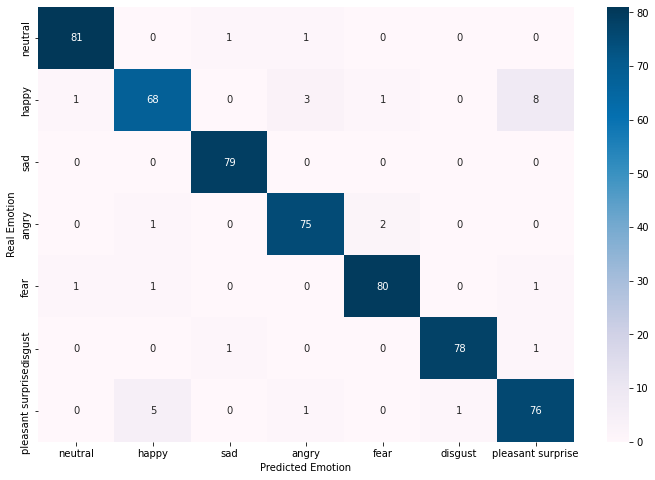

In [24]:
# Menampilkan confusion matrix hasil evaluasi dan tingkat akurasi dari masing-masing kategori
predictions = model_predict(model, x_val)
show_confusion_matrix(predictions, y_val_class, 'PuBu')

### Simpan Model dan Wight

In [25]:
# Simpan model dan weight yang terbaik ke dalam file h5
model.save(model_path)
model.save_weights(weight_path)

### Load Model dan Weight

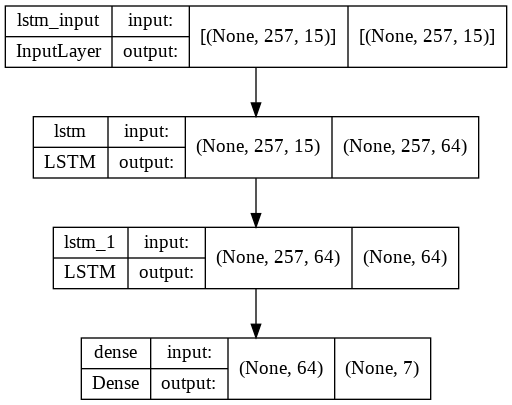

In [26]:
# Load model untuk keperluan prediksi ulang tanpa melakukan fitting ulang model
new_model = tf.keras.models.load_model(model_path)
new_model.load_weights(weight_path)

new_model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Tampilkan dalam plot
tf.keras.utils.plot_model(new_model, 
                          to_file = folder_path + '/model.png', 
                          show_shapes = True, 
                          show_layer_names = True)

In [27]:
loss, acc = new_model.evaluate(x_test, y_test_class, verbose=2)
print('New model, loss: {:5.2f}%, accuracy: {:5.2f}%'.format(100 * loss, 100 * acc))

9/9 - 3s - loss: 0.2133 - categorical_accuracy: 0.9377 - 3s/epoch - 345ms/step
New model, loss: 21.33%, accuracy: 93.77%


CM Diagonal :  [32 37 43 36 33 35 40]
CM Horizontal :  [33 43 43 37 34 39 44]

Hasil akurasi dari prediksi data validasi :
neutral : 96.97%
happy : 86.05%
sad : 100.00%
angry : 97.30%
fear : 97.06%
disgust : 89.74%
pleasant surprise : 90.91%

Confusion Matrix :


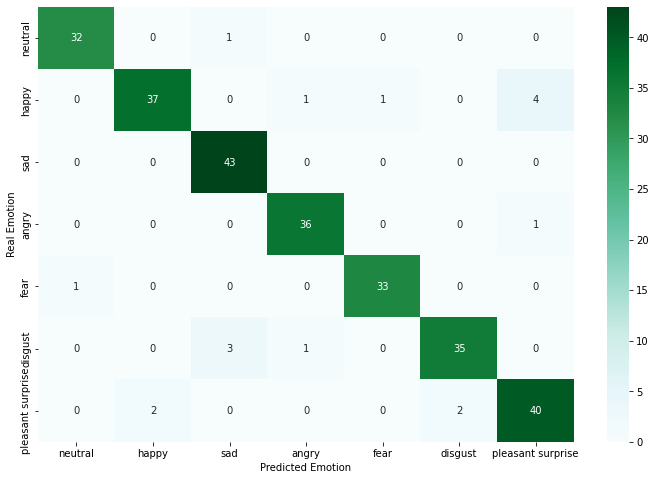

In [28]:
predictions = model_predict(new_model, x_test)
show_confusion_matrix(predictions, y_test_class, 'BuGn')

## Test Data Real

In [29]:
test_path = folder_path + '/data_2_predict'

rms_pred = []
zcr_pred = []
mfcc_pred = []
audio_name_list = []
for subdir, dirs, files in os.walk(test_path):
  for file_name in files:                  
    f1, f2, f3 =  get_feature(subdir, file_name)
    rms_pred.append(f1)
    zcr_pred.append(f2)
    mfcc_pred.append(f3)
    audio_name_list.append(file_name)

f_pred_zcr = np.asarray(zcr_pred).astype('float32')
f_pred_zcr = np.swapaxes(f_pred_zcr,1,2)
print('ZCR : ', f_pred_zcr.shape)

f_pred_rms = np.asarray(rms_pred).astype('float32')
f_pred_rms = np.swapaxes(f_pred_rms,1,2)
print('RMS : ', f_pred_rms.shape)

f_pred_mfcc = np.asarray(mfcc_pred).astype('float32')
f_pred_mfcc = np.swapaxes(f_pred_mfcc,1,2)
print('MFCC:', f_pred_mfcc.shape)

X_2_pred = np.concatenate((f_pred_zcr, f_pred_rms, f_pred_mfcc), axis=2)
predictions = model_predict(new_model, X_2_pred)
y_pred_class = np.argmax(predictions, axis=1)
print()
print('Hasil Prediksi : ')

i = 0
for audio_name in audio_name_list :
  print(audio_name, "\t", columns[i])
  i = i + 1

AxisError: ignored

Sampling Rate :  22050


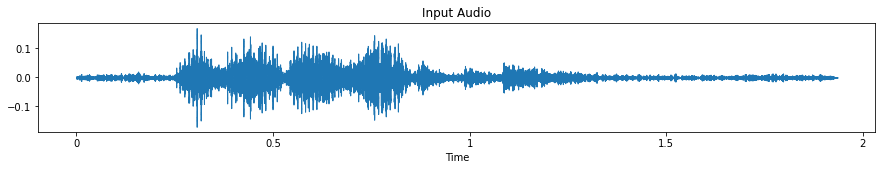

In [ ]:
file_name = test_path + '/1001_IOM_SAD_XX.wav'
voice, sampling_rate = librosa.load(file_name)
plt.figure(figsize=(15,2))
plt.title("Input Audio")
librosa.display.waveshow(voice, sr = sampling_rate)
print("Sampling Rate : ", sampling_rate)
ipd.Audio(file_name)